# DS2 Take-Home Assignment - Nicolas Fernandez
### Kaggle Competition - Predicting Online News Popularity
The task is to create the best possible model for predicting the popularity of a news article from mashable.com and perform best in a kaggle.com competition being held.

The dataset being used can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/data) and a link to the kaggle competition overview can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/overview).

The data itself, as mentioned above, comes from mashable.com and is data from articles that appeared on the site two years past January 8, 2015 (when the dataset was acquired) or later. The goal is to predict which articles are shared the most on social media using the binary `is_popular` column within the dataset denoting an article being popular with a 1, 0 if not. From the competition, the data is already split into `train.csv` and `test.csv` with the latter being used to generate predictions on popularity for submission to the competition. `train.csv` will be split into training and test sets for creating and testing predictive models.

Both the train and test csv's have a column `article_id` that is solely the index of the articles in the data. This will be used as the index for the dataframes when loaded in. The numbers don't exactly match up with the amount of observations in the dataset but that's not a problem. This will be necessary later when creating the Kaggle submission.

The submission scores will be calculated using AUC scores as the loss function per specifications of the competition.

## Loading Data and EDA

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np

# Loading train data from csv locally and viewing the contents
data = pd.read_csv('train.csv', index_col='article_id')
display(data.head())
data.info()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular
article_id,,,,,,,,,,,,,,,,,,,,,
1,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,0.10,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0
3,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,0.05,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0
5,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.10,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0
6,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.10,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0
7,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.05,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 29733 entries, 1 to 39643
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null  int6

There are no NaN values within the data however there could imputed values that can be interpreted as missing. This will be explored further. Along with this, per the dataset column descriptions on Kaggle, there are certain columns that are either difficult to interpret or can be considered superfluous, for instance all of the `kw` columns except for `kw_avg_avg` which is the average amount of social media shares that the keywords used in the article in question have across all articles. The `self_reference` columns will also be dropped since these refer to the shares to other articles within Mashable but using this would lower external validity of the model since it would only aid prediction of Mashable articles overall.

One question to be explored if a dummy variable is necessary for each day of the week or only weekends are important, and same for the genre of the article.

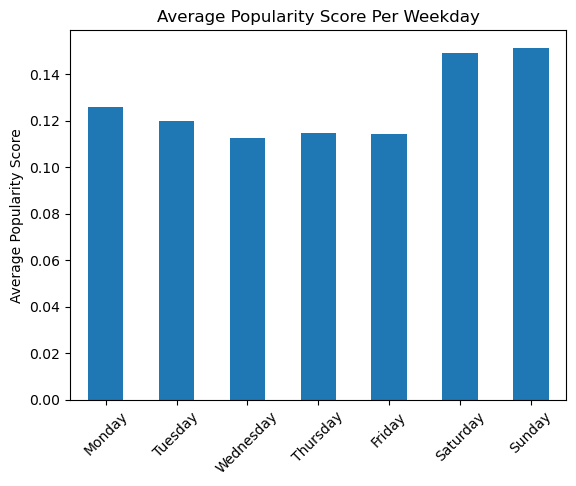

In [2]:
# Importing required libraries
import matplotlib.pyplot as plt

# Creating list of uninterpretable and/or superfluous columns from data
drop_cols = []
for col in data.columns:
    if col.startswith('n_non_'):
        drop_cols.append(col)
    elif 'hrefs' in col:
        drop_cols.append(col)
    elif col.startswith('kw_') and col != 'kw_avg_avg':
        drop_cols.append(col)
    elif col.startswith('self_'):
        drop_cols.append(col)
    elif col.startswith('LDA_'):
        drop_cols.append(col)
    elif 'polarity' in col and not col.startswith('avg') and not col.startswith('global_') and not col.startswith('title'):
        drop_cols.append(col)
    elif 'subjectivity' in col and not col.startswith('global') and not col.startswith('title'):
        drop_cols.append(col)

# Dropping columns from list created above
data.drop(columns=drop_cols, inplace=True)

# Getting all weekday columns set to a list
weekdays = [col for col in data.columns if col.startswith('weekday_')]
weekday_names = [day.replace('weekday_is_', '').capitalize() for day in weekdays]

# Creating dataframe that shows average popularity score for each weekday
avg_weekday_pop_df = data.groupby(weekdays)['is_popular'].mean()[::-1]

# Creating a bar plot to show the average scores per weekday
avg_weekday_pop_df.plot(kind='bar')
plt.xlabel(None)
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score Per Weekday')

plt.xticks(range(len(weekday_names)), weekday_names, rotation=45)

plt.show()

From this plot we can see that the most influential days from the data are the weekends (Saturday and Sunday) with the earlier weekdays being slightly more influential than the latter ones. Using this information, the dummy variables for each weekday will be dropped, the already existing `is_weekend` column will be kept but renamed to `d_weekend` to flag it as a dummy variable, and a new dummy variable `d_mon_tues` will be created to flag whether the article was released on either Monday or Tuesday.

Next, the same examination will be done for article genres.

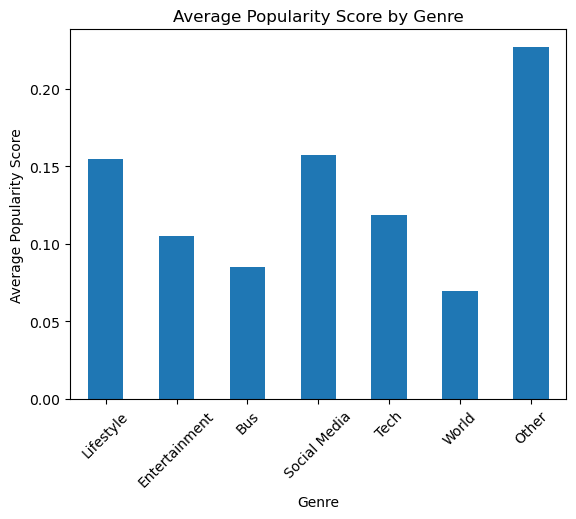

In [3]:
# Creating Monday/Tuesday dummy variable
data['d_mon_tues'] = data['weekday_is_monday'] + data['weekday_is_tuesday']

# Renaming is_weekend to d_weekend
data.rename(columns={'is_weekend': 'd_weekend'}, inplace=True)

# Dropping all weekday_is_ columns from data since they are no longer necessary
data.drop(columns=weekdays, inplace=True)

# Repeating the same plot above but with article genres
genres = [col for col in data.columns if col.startswith('data_channel_is_')]
genre_names = [genre.replace('data_channel_is_', '').capitalize() for genre in genres]
genre_names[genre_names.index('Socmed')] = 'Social Media'
genre_names.append('Other')

genre_pop_df = data.groupby(genres)['is_popular'].mean()[::-1]

genre_pop_df.plot(kind='bar')

plt.xlabel('Genre')
plt.ylabel('Average Popularity Score')
plt.title('Average Popularity Score by Genre')

plt.xticks(range(len(genre_names)), genre_names, rotation=45)

plt.show()

From reviewing the data there were a couple observations:
- Despite there being 6 genre classifiers in the data there is a 7th occurence for articles that don't fall under any of the labelled genres. For the purposes of the plot they were labelled as `Other`
- Articles not falling into any of the 6 classified genres are significantly more popular than the rest
- Amongst the articles denoted by a specific genre, the `Lifestyle` and `Social Media` genres are the most significant predictors, roughly the same
- The `World` genre appears to be the least popular genre, somewhat significantly so

From this analysis it appears that the genre of the article has significance for determining popularity but that different groupings may not make sense. These columns will be left as is within the data but renamed to flag them as dummy variables with the following syntax: `d_genre_`

Next a histogram of the `average_token_length` will be examined.

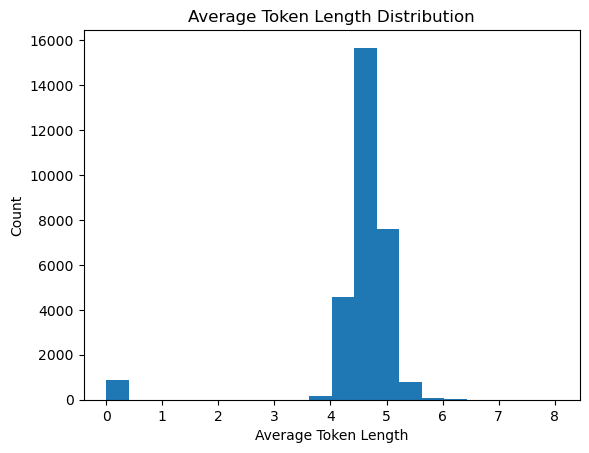

In [4]:
# Renaming genre dummy variables
[data.rename(columns={genre: genre.replace('data_channel_is_', 'd_genre_')}, inplace=True) for genre in genres]

# Generating a historgram of `average_token_length`
plt.hist(data['average_token_length'], bins=20)

plt.xlabel('Average Token Length')
plt.ylabel('Count')
plt.title('Average Token Length Distribution')

plt.show()

From this we can see that the distribution of average token length of articles in the data is approximating a normal distribution around a mean of roughly 4.5. The noteworthy values here are the significant portion of values with an average token length of 0. These occurrences will be explored in more depth to figure out what exactly these represent. It is likely that these articles are slideshows and/or videos rather than traditional prose (or a combination thereof).

In [5]:
# Viewing descriptive statistics for occurences where `average_token_length` equals 0
data[data['average_token_length'] == 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,d_mon_tues
count,867.000000,867.000000,867.0,867.0,867.000000,867.000000,867.0,867.000000,867.000000,867.000000,...,867.0,867.0,867.0,867.0,867.0,867.0,867.000000,867.000000,867.000000,867.000000
mean,164.573241,10.850058,0.0,0.0,3.747405,0.792388,0.0,7.471742,0.018454,0.154556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.349305,0.088811,0.191465,0.359862
std,167.269141,2.036760,0.0,0.0,8.606464,1.155682,0.0,1.663373,0.134665,0.361689,...,0.0,0.0,0.0,0.0,0.0,0.0,0.339876,0.295841,0.393681,0.480237
min,9.000000,5.000000,0.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.000000,0.000000,0.000000
25%,57.500000,9.000000,0.0,0.0,0.000000,0.000000,0.0,6.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,101.000000,11.000000,0.0,0.0,0.000000,1.000000,0.0,7.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.000000
75%,191.000000,12.000000,0.0,0.0,1.000000,1.000000,0.0,9.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.250000,0.000000,1.000000
max,715.000000,16.000000,0.0,0.0,100.000000,24.000000,0.0,10.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


In [6]:
# Viewing descriptive statistics for occurrences where `average_token_length` is not equal to 0
data[data['average_token_length'] != 0].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,d_mon_tues
count,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,...,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000,28866.000000
mean,361.384570,10.377018,561.377780,0.571748,4.547876,1.277697,4.688573,7.223550,0.054216,0.178064,...,0.040856,0.017060,0.703707,0.296120,0.364653,-0.267509,0.279852,0.069116,0.119552,0.354847
std,212.907893,2.110788,466.609145,4.124008,8.200756,4.246004,0.283318,1.917459,0.226447,0.382573,...,0.016245,0.010495,0.150100,0.149865,0.085560,0.122140,0.322743,0.263360,0.324443,0.478475
min,8.000000,2.000000,18.000000,0.114964,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
25%,174.250000,9.000000,258.000000,0.477781,1.000000,0.000000,4.496245,6.000000,0.000000,0.000000,...,0.029499,0.010152,0.613636,0.200000,0.311761,-0.331818,0.000000,0.000000,0.000000,0.000000
50%,350.000000,10.000000,422.000000,0.543646,1.000000,0.000000,4.676255,7.000000,0.000000,0.000000,...,0.039624,0.015603,0.714286,0.285714,0.361801,-0.256944,0.125000,0.000000,0.000000,0.000000
75%,548.000000,12.000000,725.000000,0.611792,4.000000,1.000000,4.863729,9.000000,0.000000,0.000000,...,0.050724,0.021978,0.800000,0.385965,0.413644,-0.193056,0.500000,0.136364,0.000000,1.000000
max,731.000000,23.000000,8474.000000,701.000000,111.000000,91.000000,8.041534,10.000000,1.000000,1.000000,...,0.155488,0.162037,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


Viewing of the descriptive statistics of the two scenarios it appears as if the original assumption was correct, that these occurrences in the data are slideshows and/or videos with no text in the content. They cannot be dropped however as they are clearly not errors in the data entry. A dummy variable `d_no_words` will be created to represent this scenario.

Another thing noted from the non-zero average token length is that the standard deviation of `n_tokens_content` is very large. For reference, the values at and above the 99% range will be viewed closer.

In [7]:
# Creating a dummy variable for when `average_token_length` is equal 0
data['d_no_words'] = (data['average_token_length'] == 0).astype(int)

# Calculating the 95% of n_tokens_content
content_99 = data['n_tokens_content'].quantile(.99)

# Viewing descriptive statistics at and above 99% quantile value
data[data['n_tokens_content'] >= content_99].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,...,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.0
mean,342.788591,10.479866,2976.929530,0.327987,18.073826,4.348993,4.579441,7.761745,0.067114,0.231544,...,0.018329,0.709949,0.290051,0.377829,-0.284523,0.304710,0.128655,0.187919,0.362416,0.0
std,189.989010,2.412355,918.705812,0.057942,21.441988,14.483208,0.242161,1.922824,0.250640,0.422528,...,0.006269,0.090700,0.090700,0.047178,0.057095,0.333556,0.270272,0.391305,0.481507,0.0
min,8.000000,5.000000,2258.000000,0.114964,0.000000,0.000000,3.785066,1.000000,0.000000,0.000000,...,0.000402,0.435540,0.006993,0.271258,-0.473922,0.000000,-0.600000,0.000000,0.000000,0.0
25%,185.750000,9.000000,2430.750000,0.298184,1.000000,0.000000,4.433234,6.000000,0.000000,0.000000,...,0.015049,0.654583,0.232980,0.346970,-0.319522,0.000000,0.000000,0.000000,0.000000,0.0
50%,320.000000,11.000000,2671.000000,0.332264,10.000000,0.000000,4.592008,8.000000,0.000000,0.000000,...,0.018180,0.714286,0.285714,0.376359,-0.273092,0.233333,0.000000,0.000000,0.000000,0.0
75%,480.500000,12.000000,3138.250000,0.365665,30.750000,1.000000,4.721814,10.000000,0.000000,0.000000,...,0.021658,0.767020,0.345417,0.408152,-0.240777,0.500000,0.250000,0.000000,1.000000,0.0
max,713.000000,18.000000,8474.000000,0.462878,111.000000,75.000000,5.318665,10.000000,1.000000,1.000000,...,0.044359,0.993007,0.564460,0.511385,-0.134524,1.000000,1.000000,1.000000,1.000000,0.0


In [8]:
# Viewing descriptive statistics at 75% quartile and below
content_75 = data['n_tokens_content'].quantile(.75)
data[data['n_tokens_content'] <= content_75].describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
count,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,...,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000,22300.000000
mean,364.375516,10.378206,338.894081,0.563366,3.370628,1.028879,4.519160,7.153722,0.049776,0.165471,...,0.015857,0.679395,0.281547,0.349722,-0.253503,0.280851,0.067488,0.119327,0.357354,0.038879
std,216.259182,2.089012,174.042729,0.140219,5.950367,3.205206,0.952478,1.891243,0.217486,0.371613,...,0.011026,0.207721,0.166157,0.115048,0.141229,0.322381,0.259226,0.324181,0.479231,0.193311
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,170.000000,9.000000,209.000000,0.520773,1.000000,0.000000,4.482534,6.000000,0.000000,0.000000,...,0.008439,0.592593,0.166667,0.297192,-0.331944,0.000000,0.000000,0.000000,0.000000,0.000000
50%,355.000000,10.000000,318.000000,0.572816,1.000000,0.000000,4.677923,7.000000,0.000000,0.000000,...,0.014327,0.714286,0.272727,0.355223,-0.245833,0.144444,0.000000,0.000000,0.000000,0.000000
75%,558.000000,12.000000,466.000000,0.632083,2.000000,1.000000,4.872306,9.000000,0.000000,0.000000,...,0.021429,0.812500,0.384615,0.415049,-0.166667,0.500000,0.136364,0.000000,1.000000,0.000000
max,731.000000,19.000000,712.000000,1.000000,100.000000,59.000000,8.041534,10.000000,1.000000,1.000000,...,0.162037,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# Viewing the last 20 observations when sorted by n_tokens_content
data.sort_values('n_tokens_content').tail(20)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_imgs,num_videos,average_token_length,num_keywords,d_genre_lifestyle,d_genre_entertainment,...,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,avg_negative_polarity,title_subjectivity,title_sentiment_polarity,is_popular,d_mon_tues,d_no_words
article_id,,,,,,,,,,,,,,,,,,,,,
28698,399,8,4155,0.315675,1,0,4.765102,9,0,0,...,0.023105,0.617530,0.382470,0.360860,-0.219591,0.062500,0.000000,0,0,0
36127,427,14,4172,0.312469,1,0,4.553931,10,0,0,...,0.018456,0.624390,0.375610,0.356407,-0.235841,0.266667,0.066667,0,0,0
21810,217,8,4306,0.379726,1,1,4.666280,10,0,1,...,0.024152,0.671924,0.328076,0.389660,-0.353855,0.000000,0.000000,0,0,0
6441,170,12,4331,0.304833,1,0,4.580236,8,0,0,...,0.022397,0.726761,0.273239,0.369942,-0.269213,0.600000,0.700000,1,1,0
27810,146,10,4452,0.293559,1,0,4.746181,5,0,0,...,0.015723,0.761092,0.238908,0.363106,-0.282290,0.000000,0.000000,0,0,0
20214,319,14,4462,0.346752,13,0,4.634469,10,0,0,...,0.021515,0.593220,0.406780,0.283668,-0.223446,0.000000,0.000000,0,0,0
154,441,12,4514,0.312103,50,1,4.315463,6,0,1,...,0.037661,0.512894,0.487106,0.370937,-0.310585,0.622222,0.044444,0,0,0
22290,101,9,4574,0.322843,5,0,4.430695,5,0,1,...,0.017272,0.700758,0.299242,0.341084,-0.258193,0.000000,0.000000,0,1,0
35561,228,11,4661,0.264441,7,13,4.519631,6,0,0,...,0.021240,0.600806,0.399194,0.358083,-0.404658,0.850000,-0.300000,0,0,0


In [10]:
# Viewing overall distribution of articles denoted as popular vs not popular
data['is_popular'].value_counts()

is_popular
0    26116
1     3617
Name: count, dtype: int64

From reviewing the descriptive statistics and especially the mean values of `is_popular` for the different quantiles it appears that content length is significant for determining popularity and therefore will not be curtailed/processed to adjust for potential extreme values. When sorting the dataframe by `n_tokens_content` and viewing the 20 largest observations the dropoff is not significantly dramatic enough to warrant potentially dropping those data points. It might also hamper the prediction power of the models.

Now the distribution of `kw_avg_avg` will be checked.

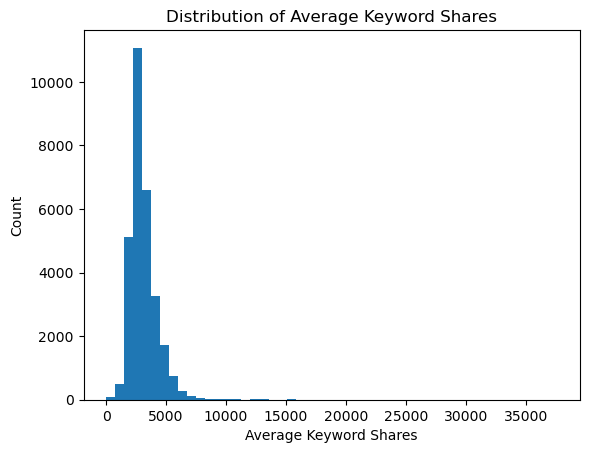

In [11]:
# Plottig the distribution of kw_avg_avg
plt.hist(data['kw_avg_avg'], bins=50)

plt.xlabel('Average Keyword Shares')
plt.ylabel('Count')
plt.title('Distribution of Average Keyword Shares')

plt.show()

Similar to `n_tokens_content` we have a distribution that is somewhat normal but has a very long right tail.

## Feature Engineering
Some feature engineering will be performed on the data to account for any non-linearity in the data as well as potentially capture additional information that is not being captured by the base data points. All feature engineered variables will begin with the `f_` tag.

One such thing would be examine the distribution of log values for `n_tokens_content` and `kw_avg_avg` to see if it creates a more normal distribution along with taking quadratics of certain variables to capture potential non-linearity in the data, as mentioned above.

C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


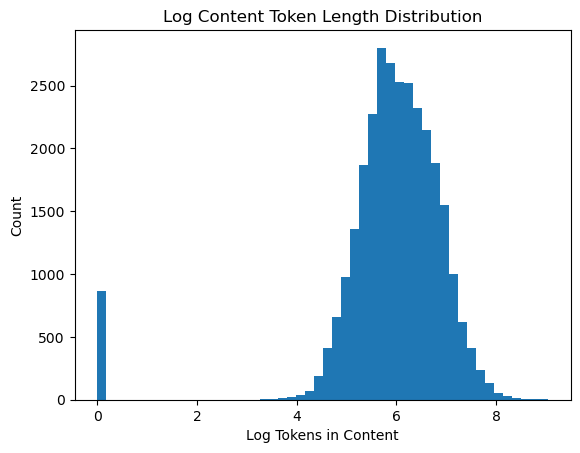

In [12]:
# Checking the distribution plot for the log values of n_tokens_content, setting the values to 0 where 
plt.hist(np.where(data['n_tokens_content'] == 0, 0, np.log(data['n_tokens_content'])), bins=50)

plt.xlabel('Log Tokens in Content')
plt.ylabel('Count')
plt.title('Log Content Token Length Distribution')

plt.show()

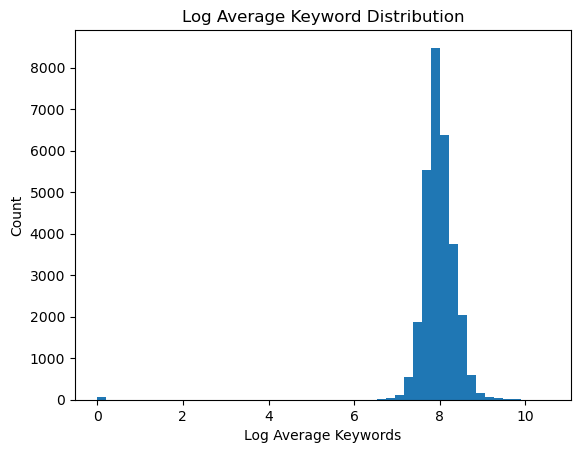

In [13]:
# Performing the same task for kw_avg_avg
plt.hist(np.where(data['kw_avg_avg'] == 0, 0, np.log(data['kw_avg_avg'])), bins=50)

plt.xlabel('Log Average Keywords')
plt.ylabel('Count')
plt.title('Log Average Keyword Distribution')

plt.show()

For occurrences where the number of tokens was equal to 0 the value of 0 was imputted for the log. The warnings generated are not actual issues. The log transformations of `n_tokens_content` and `kw_avg_avg` create more normal distributions and therefore will be used.

In [14]:
# Creating the log values as specified
data['f_log_tokens_content'] = np.where(data['n_tokens_content'] == 0, 0, np.log(data['n_tokens_content']))
data['f_log_kw_avg_avg'] = np.where(data['kw_avg_avg'] == 0, 0, np.log(data['kw_avg_avg']))

# Creating quadratic variables
data['f_n_tokens_title_sq'] = np.power(data['n_tokens_title'], 2)
data['f_num_imgs_sq'] = np.power(data['num_imgs'], 2)
data['f_num_keywords'] = np.power(data['num_keywords'], 2)

C:\Users\Xrona\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Training, Validation, and Test Splits

The training, validation and test splits for creating models will be created using `is_popular` as the target variable. An initial 80/20% split will be made of the data to create a training and test split for OLS and machine learing models like Random Forest and Gradient Boosting models. Afterwards, an additional split of this training set will be made in order to create a validation set for Neural Network models that will be created again using an 80/20% split. The non-neural network models will use the original training split for training of the models. A pseudo-random seed will be generated using the due date for the Kaggle competition as the seed number (20240419).

For the train_test_split the `stratify` parameter will be used in order to preserve the the distribution of `is_popular` given that it number of popular articles is inbalanced in the dataset.

In [15]:
# Importing required function
from sklearn.model_selection import train_test_split

# Setting the pseudo random seed
prng = np.random.RandomState(20240419)

# Creating X and y variables for splitting
X = data.drop(columns=['is_popular'])
y = data['is_popular']

# Creating initial training/test split of data, using stratify to preserve distribution of is_popular
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=prng)

# Creating a validation split
nnX_train, nnX_val, nny_train, nny_val = train_test_split(X_train, y_train, test_size=.2, stratify=y_train, random_state=prng)

## Benchmark and Base Feature OLS Models
The benchmark and OLS models will be created below.

### Benchmark Model
A simple benchmark model simply using the mean value of `is_popular` will be used.

In [16]:
# Importing required function
from sklearn.metrics import roc_auc_score

# Creating benchmark model
benchmark = np.mean(y_train)

# Calculating the AUC scores for the benchmark model
train_auc = roc_auc_score(y_train, np.repeat(benchmark, len(y_train)))
test_auc = roc_auc_score(y_test, np.repeat(benchmark, len(y_test)))
benchmark_pred = ['Benchmark', train_auc, test_auc]

# Storing and displaying results in a dataframe
results = pd.DataFrame([benchmark_pred], columns = ['Model', 'Train AUC', 'Test AUC'])
results

,Model,Train AUC,Test AUC
0,Benchmark,0.5,0.5


The results of the benchmark model is .5 forboth the training and test sets. This means that it doesn't do any better than predicting the outcome randomly. This makes it a perfect benchmark model.

### Single Feature Logit
This model will only include a single feature and will be used as the benchmark going forward. The feature selected will be `d_weekend` as the day of the week seems to be a significant predictor for popularity. ll predictions are made for probabilities. This means using `predict_proba()` instead of `predict()`. Grabbing the `[:,1]` element of the probability is to denote the prediction of the probability that the article is popular.

In [17]:
# Importing required functions
from sklearn.linear_model import LogisticRegression

# Creating a logistic regression model and fitting it to the data
logit_single = LogisticRegression().fit(X_train[['n_tokens_content']], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_single.predict_proba(X_train[['n_tokens_content']])[:,1])
test_auc = roc_auc_score(y_test, logit_single.predict_proba(X_test[['n_tokens_content']])[:,1])
logit_single_pred = ['Single Feature Logit', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_single_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.476133,0.489732


The single feature logit model is doing a worse job than the benchmark which meaninng it is worse than randomly selecting which article is popular. Despite what we saw earlier, it appears that checking wether the article was published on the weekend as our lone variable is worse than randomly predicting popularity.

### Logit Using All Base Features

In [18]:
# Getting all base features from dataset
base_features = [col for col in X.columns if not col.startswith('f_')]

# Creating and fitting the model, setting max iterations to 2000 to allow convergence
logit_base = LogisticRegression(max_iter=2000).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, logit_base.predict_proba(X_test[base_features])[:,1])
logit_base_pred = ['Logit Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.476133,0.489732
2,Logit Base Features,0.674945,0.661767


Using all the base features does a much better job than only 1 feature. With scores above .66 for both sets it means that the logit with base features is better at determining popularity than randomly predicting and is capturing some of the information in the data.

### Logit with Interaction Terms on Base Features
First order interactions only will be used (no quadratics) on only base features.

In [19]:
# Importing required method
from sklearn.preprocessing import PolynomialFeatures

# Creating interaction terms in training data
interactions = PolynomialFeatures(degree=1, interaction_only=True)
X_train_base_interactions = interactions.fit_transform(X_train[base_features])

# Fitting Logit model to training data with interaction terms
logit_base_interactions = LogisticRegression(max_iter=2000).fit(X_train_base_interactions, y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, logit_base_interactions.predict_proba(X_train_base_interactions)[:,1])
test_auc = roc_auc_score(y_test, logit_base_interactions.predict_proba(interactions.transform(X_test[base_features]))[:,1])
logit_base_interactions_pred = ['Logit Base Interactions', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = logit_base_interactions_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.476133,0.489732
2,Logit Base Features,0.674945,0.661767
3,Logit Base Interactions,0.677057,0.663359


First order interaction terms on the base features very marginally improves the AUC scores which means the interaction terms aren't really capturing any relationships in the data.

### LASSO Version of Previous Model
The L1 penalty will be used in the prior model to penalize any overfitting that may be occurring.

In [20]:
# Tweaking the previous model to turn it into a LASSO
lasso_base_interactions = LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000).fit(X_train_base_interactions, y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, lasso_base_interactions.predict_proba(X_train_base_interactions)[:,1])
test_auc = roc_auc_score(y_test, lasso_base_interactions.predict_proba(interactions.transform(X_test[base_features]))[:,1])
lasso_base_interactions_pred = ['LASSO Base Interactions', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = lasso_base_interactions_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.476133,0.489732
2,Logit Base Features,0.674945,0.661767
3,Logit Base Interactions,0.677057,0.663359
4,LASSO Base Interactions,0.682153,0.667744


The LASSO model again marginally improved the AUC scores which means there was a bit of overfitting occurring with the interaction terms that the LASSO accounted for with the lambda penalty. It was not a noteworthy improvement however.

## Base Feature Machine Learing Models
Below Machine Learing models using exclusively base features will be created. Since there are no categorical variables in the training/test data being used there will be no need for a pipeline 

### Random Forest Base Features
Creating a Random Forest model with a minimum sample split of 20 to prevent overfitting.

In [21]:
# Importing required method
from sklearn.ensemble import RandomForestClassifier

# Creating and fitting the RF to training data using prng defined earlier. Parameters set to prevent overfitting
rf_base = RandomForestClassifier(min_samples_split=20, random_state=prng).fit(X_train[base_features], y_train)

# Creating predictions and calculating AUC score
train_auc = roc_auc_score(y_train, rf_base.predict_proba(X_train[base_features])[:,1])
test_auc = roc_auc_score(y_test, rf_base.predict_proba(X_test[base_features])[:,1])
rf_base_pred = ['RF Base Features', train_auc, test_auc]

# Adding to results
results.loc[len(results)] = rf_base_pred
results

,Model,Train AUC,Test AUC
0,Benchmark,0.500000,0.500000
1,Single Feature Logit,0.476133,0.489732
2,Logit Base Features,0.674945,0.661767
3,Logit Base Interactions,0.677057,0.663359
4,LASSO Base Interactions,0.682153,0.667744
5,RF Base Features,0.997346,0.684385
